# Predicting Shots per Game by Kobe Bryant

![title](./img/kobe_title.jpg)

In this post I'll be demonstrating regularization penalties through linear models that predict how many shots Kobe Bryant made per game in his career. <br/><br/>
Please note I don't follow the NBA and thus don't have domain knowledge for this dataset. As a disclaimer, I believe domain knowledge is a key element in any analysis. That being said it's always been interesting to analyze data without any biases from knowing about the topic. It offers fresh perspective and the ability to truly allow the data to tell a story rather than trying to shape the story based on your preconceived notions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')
kobe.head()

SHOTS_MADE  AWAY_GAME  SEASON_OPPONENT:atl:1996-97  \
0         0.0          0                          0.0   
1         0.0          1                          0.0   
2         2.0          1                          0.0   
3         2.0          1                          0.0   
4         0.0          0                          1.0   

   SEASON_OPPONENT:atl:1997-98  SEASON_OPPONENT:atl:1999-00  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   SEASON_OPPONENT:atl:2000-01  SEASON_OPPONENT:atl:2001-02  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   SEASON_OPPONENT:atl:2002-03  SEASON_OPPONENT:atl:2003-04  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   SEASON_OPPONENT:atl:2004-05         ...          \
0                          0.0         ...           
1                          0.0         ...           
2                          0.0         ...           
3                          0.0         ...           
4                          0.0         ...           

   ACTION_TYPE:tip_layup_shot  ACTION_TYPE:tip_shot  \
0                         0.0                   0.0   
1                         0.0                   0.0   
2                         0.0                   0.0   
3                         0.0                   0.0   
4                         0.0                   0.0   

   ACTION_TYPE:turnaround_bank_shot  \
0                               0.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   ACTION_TYPE:turnaround_fadeaway_bank_jump_shot  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   ACTION_TYPE:turnaround_fadeaway_shot  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   ACTION_TYPE:turnaround_finger_roll_shot  ACTION_TYPE:turnaround_hook_shot  \
0                                      0.0                               0.0   
1                                      0.0                               0.0   
2                                      0.0                               0.0   
3                                      0.0                               0.0   
4                                      0.0                               0.0   

   ACTION_TYPE:turnaround_jump_shot  SEASON_GAME_NUMBER  CAREER_GAME_NUMBER  
0                               0.0                   1                   1  
1                               0.0                   2                   2  
2                               0.0                   3                   3  
3                               0.0                   4                   4  
4                               0.0                   5                   5  

[5 rows x 645 columns]

In [3]:
kobe.shape

(1558, 645)

Regularization can be useful for this dataset because with the high number of features, the model can have high complexity and may be prone to be overfit. By using regularization, we can reduce the model's variance inherent with complex models.

## Preprocessing

In [4]:
# Set target vector and feature matrix
target = kobe['SHOTS_MADE']
nc = [x for x in kobe.columns if x != 'SHOTS_MADE']
X = kobe.loc[:, nc].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, \
                                                    random_state=1337)

# Use standard scaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Modeling

In [5]:
# Test base linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Cross-validation
xfold_mean = np.mean(cross_val_score(lr, X_train, y_train, cv=5))
xfold_std = np.std(cross_val_score(lr, X_train, y_train, cv=5))

print('crossfold mean: ', xfold_mean)
print('crossfold std: ', xfold_std)

crossfold mean:  -4.40627525789e+28
crossfold std:  1.1718160823e+28


And you thought you saw bad model performmance before. Let's try this again with L2 regularization. 

In [6]:
# RidgeCV performs best searching alphas through logarithmic space. 
ridgeCV = RidgeCV(alphas=(np.logspace(-5, 5, 100)))
ridgeCV.fit(X_train, y_train)

# Best alpha
print('Best alpha: ', ridgeCV.alpha_)

# Cross-validation
xfold_mean_ridge = np.mean(cross_val_score(ridgeCV, X_train, y_train, cv=5))
xfold_std_ridge = np.std(cross_val_score(ridgeCV, X_train, y_train, cv=5))

print('Ridge crossfold mean: ', xfold_mean_ridge)
print('Ridge crossfold std: ', xfold_std_ridge)
print('Validation accuracy: ', ridgeCV.score(X_test, y_test))

Best alpha:  1519.91108295
Ridge crossfold mean:  0.619968376475
Ridge crossfold std:  0.0281234152548
Validation accuracy:  0.603733966375


By running a linear model with L2 regularlization, we're able to see a huge bump in accuracy. With a feature set in the hundreds- this was expected. The regularization is helping the model be less overfit by penalizing features with higher coefficients and dampening features with very small coefficients. <br/><br/>
Let's run a Lasso regression to see how that will perform against the Ridge regression.

In [7]:
# LassoCV performs best searching for alpha through linear space. By default, LassoCV
# will decide itself what alphas to use.
lassoCV = LassoCV()
lassoCV.fit(X_train, y_train)

# Best alpha
print('Best alpha: ', lassoCV.alpha_)

xfold_mean_lasso = np.mean(cross_val_score(lassoCV, X_train, y_train, cv=5))
xfold_std_lasso = np.std(cross_val_score(lassoCV, X_train, y_train, cv=5))

print('LassoCV crossfold mean: ', xfold_mean_lasso)
print('LassoCV crossfold std: ', xfold_std_lasso)
print('Validation accuracy: ', lassoCV.score(X_test, y_test))

Best alpha:  0.10792078438
LassoCV crossfold mean:  0.639611906999
LassoCV crossfold std:  0.0163110524353
Validation accuracy:  0.62856668496


The lasso regression performed slightly better than our ridge model above. Because L1 regularization allows coefficients to 'zero-out' opposed from L2 regularlization which doesn't allow coefficients to hit zero, I suspect this helped lessen the overfitting that was prone with a model with this high of a complexity. <br/><br/>
Let's take a look at how many coefficients ended up zero-ing out from the L1 regularization.

In [8]:
zero_coef_count = np.count_nonzero(lassoCV.coef_==0)

print('Number of "zero-ed out" feature coefficients: ', zero_coef_count)
print('Count of total features: ', len(lassoCV.coef_))
print('')
print('Percent of "zero-ed out" features: {}%'.format(round((zero_coef_count / \
                                                    len(lassoCV.coef_)) * 100, 2)))

Number of "zero-ed out" feature coefficients:  587
Count of total features:  644

Percent of "zero-ed out" features: 91.15%


Over 90% of the features in this dataset had a zero coefficient after the L1 regularization. That shows that most of the features had very little to no impact to the target. <br/><br/>
So then what were the most important features for predicting Kobe's points per game?

In [9]:
df = pd.DataFrame(kobe.loc[:, nc].columns, columns=['Features'])
df['Coefficients'] = lassoCV.coef_

df.sort_values('Coefficients', ascending=False).head(10)

Features  Coefficients
579     COMBINED_SHOT_TYPE:jump_shot      1.249313
574         SHOT_TYPE:2pt_field_goal      0.807399
566  SHOT_ZONE_BASIC:restricted_area      0.366831
577          COMBINED_SHOT_TYPE:dunk      0.335194
582                SECONDS_REMAINING      0.308373
569         SHOT_ZONE_AREA:center(c)      0.172471
575         SHOT_TYPE:3pt_field_goal      0.101126
333      SEASON_OPPONENT:nyk:2008-09      0.098314
466      SEASON_OPPONENT:sea:2004-05      0.085991
134      SEASON_OPPONENT:det:2000-01      0.049452

The above dataframe shows the top 10 features that showed the highest correlation with the points made per game for Kobe. The number of jump shots and 2pt field goals had the highest positive coefficients by a good margin compared to the rest of the features. <br/><br/>
A third regularization regression is the Elastic Net. This blends both the L1 and L2 regularizations and weighs either regularization through the parameter, 'l1_ratio' (0 = all ridge, 1 = all lasso. We'll run the elastic net model to see if we can get a boost in performance.

In [10]:
# **FYI this will take a while to run
# Try several different values for 'l1_ratio'
n = np.linspace(0.01, 1, 20)

elasticCV = ElasticNetCV(l1_ratio=n)
elasticCV.fit(X_train, y_train)

# Best alpha
print('Best alpha: ', elasticCV.alpha_)

xfold_mean_en = np.mean(cross_val_score(elasticCV, X_train, y_train, cv=5))
xfold_std_en = np.mean(cross_val_score(elasticCV, X_train, y_train, cv=5))

print('Elastic Net crossfold mean: ', xfold_mean_en)
print('Elastic Net crossfold std: ', xfold_std_en)
print('Validation accuracy: ', elasticCV.score(X_test, y_test))

Best alpha:  0.10792078438
Elastic Net crossfold mean:  0.639611906999
Elastic Net crossfold std:  0.639611906999
Validation accuracy:  0.62856668496


In [11]:
# Best l1 ratio
elasticCV.l1_ratio_

1.0

Elastic Net found that an L1 ratio of 1 (all Lasso) was the optimum value for this exmaple.

## Conclusions
In regards to the modeling, the base linear regression was not a usable model for this dataset. Once we applied regularization penalties, we began to build models that had 'okay' accuracy scores. Comparing the L1 vs L2 penalties yielded the below validation accuracy from the test set.<br/>

Ridge: 0.6037<br/>
Lasso: 0.6286<br/><br/>

Lasso beat out Ridge by a small margin. In addition, when we ran Elastic Net the l1 ratio strongly favored Lasso. The L1 regularlization zero-ed out nearly 92% of the features in the dataset which left 57 features to be used for the model. 

We can visually see the performance of our ridge and lasso models through scatter plots.

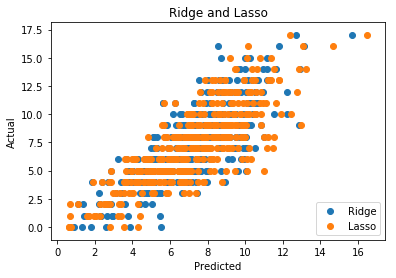

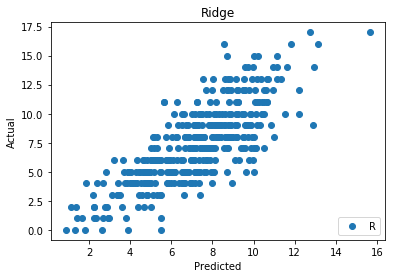

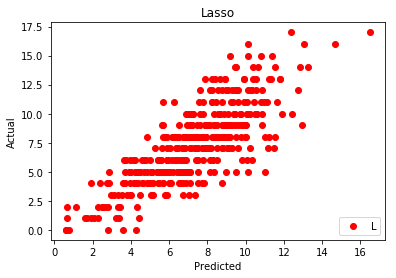

In [12]:
ridge_predictions = ridgeCV.predict(X_test)
lasso_predictions = lassoCV.predict(X_test)

plt.scatter(ridge_predictions, y_test)
plt.scatter(lasso_predictions, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend(('Ridge', 'Lasso'), loc='lower right')
plt.title('Ridge and Lasso')
plt.show()

plt.scatter(ridge_predictions, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend('Ridge', loc='lower right')
plt.title('Ridge')
plt.show()

plt.scatter(lasso_predictions, y_test, color='red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend('Lasso', loc='lower right')
plt.title('Lasso')

On a higher level, these two models performed very similarly. As next steps I would like to run some feature engineering starting with the non-zero features from the Lasso regression. In addition I expect running the data through a boosted tree would yield a model with better predictive power.<br/><br/>
All in all I don't think the current models would be good enough for Kobe Bryant given his high standards. So we'll need to continue this effort.

![title](./img/kobe_pray.jpg)

We got you Kobe.